In [1]:
import pandas as pd
import zipfile
import os
import geopandas as gpd
from sklearn.metrics import mean_squared_error
import math


## GIS maps configurations

In [2]:
# load the output area map
oa_filename = os.path.join("England_oa_2011_gen_clipped", "england_oa_2011_gen_clipped.shp")
oa = gpd.read_file(filename=oa_filename)#.set_index('code', drop=True)
#oa.index = oa.index.rename("OA11CD")
oa.head()

,code,geometry
0,E00044639,"POLYGON ((440611.474 558272.251, 440527.700 55..."
1,E00036646,"POLYGON ((330917.000 394161.000, 330937.346 39..."
2,E00092449,"POLYGON ((339836.566 367010.434, 339864.000 36..."
3,E00044638,"POLYGON ((440006.000 558293.000, 440091.001 55..."
4,E00094441,"POLYGON ((364937.770 373630.624, 364860.312 37..."


In [3]:
# load the complete lookup as dataFrame
# gis_lookup = pd.read_csv("fe6c55f0924b4734adf1cf7104a0173e_0.csv.gz")
gis_lookup = pd.read_csv(
    os.path.join('../input', 'PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.zip'),
    compression="zip",
    usecols=["ladnm", "ladcd", "oa11cd", 'msoa11cd'],
    encoding="unicode_escape",
    engine="python",
)

# Clean empty and non-England areas
gis_lookup.dropna(subset=["ladcd"], inplace=True)
discard = ["S", "W", "N", "L", "M"]
gis_lookup = gis_lookup[~gis_lookup.ladcd.str.contains("|".join(discard))]

# make LAD names dict
lad_nm_dict = gis_lookup.set_index('oa11cd', drop=True).loc[:, 'ladcd'].to_dict()

# make msoa code dict
msoa_cd_dict = gis_lookup.set_index('oa11cd', drop=True).loc[:, 'msoa11cd'].to_dict()

In [4]:
ladnm_lookup = gis_lookup.set_index("oa11cd", drop=True).loc[:, "ladnm"].to_dict()
ladcd_lookup = gis_lookup.set_index("oa11cd", drop=True).loc[:, "ladcd"].to_dict()

In [5]:
def augment(x, lookup):
    # This looks redundant, but ensures that the function works even for
    # missing values (returning empty code).
    try:
        return lookup[x]
    except:
        return

In [6]:
# Local authority name
oa["ladnm"] = oa["code"].apply(func=lambda x: augment(x, ladnm_lookup))

# Local authority code
oa["ladcd"] = oa["code"].apply(func=lambda x: augment(x, ladcd_lookup))

In [7]:
oa.head()

,code,geometry,ladnm,ladcd
0,E00044639,"POLYGON ((440611.474 558272.251, 440527.700 55...",Sunderland,E08000024
1,E00036646,"POLYGON ((330917.000 394161.000, 330937.346 39...",Wirral,E08000015
2,E00092449,"POLYGON ((339836.566 367010.434, 339864.000 36...",Cheshire West and Chester,E06000050
3,E00044638,"POLYGON ((440006.000 558293.000, 440091.001 55...",Sunderland,E08000024
4,E00094441,"POLYGON ((364937.770 373630.624, 364860.312 37...",Cheshire West and Chester,E06000050


## Some GIS visualization

<AxesSubplot:>

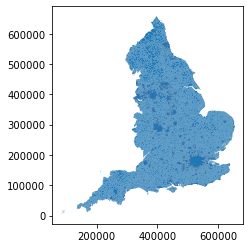

In [8]:
oa.plot()

<AxesSubplot:>

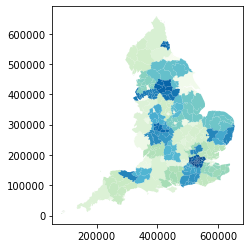

In [9]:
oa_LAD = oa.dissolve(by='ladcd')
oa_LAD.plot(cmap='GnBu')

In [10]:
oa

,code,geometry,ladnm,ladcd
0,E00044639,"POLYGON ((440611.474 558272.251, 440527.700 55...",Sunderland,E08000024
1,E00036646,"POLYGON ((330917.000 394161.000, 330937.346 39...",Wirral,E08000015
2,E00092449,"POLYGON ((339836.566 367010.434, 339864.000 36...",Cheshire West and Chester,E06000050
3,E00044638,"POLYGON ((440006.000 558293.000, 440091.001 55...",Sunderland,E08000024
4,E00094441,"POLYGON ((364937.770 373630.624, 364860.312 37...",Cheshire West and Chester,E06000050
...,...,...,...,...
171367,E00175248,"POLYGON ((529580.098 179194.237, 529586.108 17...",None,None
171368,E00169799,"POLYGON ((428969.394 433302.516, 428964.400 43...",None,None
171369,E00115865,"POLYGON ((461450.326 98059.723, 461404.687 981...",Gosport,E07000088
171370,E00175716,"POLYGON ((406120.776 286455.941, 406119.217 28...",None,None


In [11]:
oa.dropna(subset=['ladcd'], inplace=True)

<AxesSubplot:>

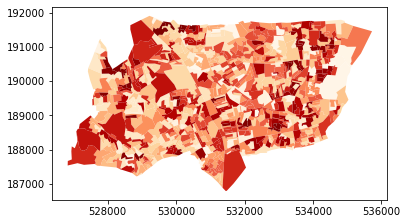

In [12]:
haringey = oa[oa.ladcd.str.match('E09000014')]
#haringey = haringey.dissolve(by='msoa')
haringey.plot(cmap='OrRd')

## EPC and Population data

In [13]:
shape_zip_file = zipfile.ZipFile(os.path.join('../output', 'SHAPE-England.zip'))
epc_zip_file = zipfile.ZipFile(os.path.join('../output', 'EPC_England.zip'))

In [14]:
population_files = [text_file.filename for text_file in shape_zip_file.infolist() if text_file.filename.endswith('.csv')]
epc_files = [text_file.filename for text_file in epc_zip_file.infolist() if text_file.filename.endswith('.csv')]


In [15]:
population_dfs = [pd.read_csv(shape_zip_file.open(file)) for file in population_files]
epc_dfs = [pd.read_csv(epc_zip_file.open(file)) for file in epc_files]

In [16]:
epc_df = pd.concat(epc_dfs)
population_df = pd.concat(population_dfs)

In [17]:
population_lads = list(population_df['LADCD'].unique())
epc_lads = list(epc_df['LADCD'].unique())

In [18]:
population_df.head(-5)

,HID,LADNM,LADCD,OA,LC4402_C_TYPACCOM,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,FLOOR_AREA,GAS,ACCOM_AGE
0,0.0,St Albans,E07000240,E00120464,3,5.0,3.0,4.0,5.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,6.0
1,1.0,St Albans,E07000240,E00120356,5,6.0,2.0,4.0,6.0,4.0,2.0,2.0,6.0,1.0,2.0,2.0,1.0
2,2.0,St Albans,E07000240,E00120387,5,3.0,4.0,2.0,6.0,3.0,2.0,1.0,2.0,3.0,3.0,2.0,3.0
3,3.0,St Albans,E07000240,E00120294,2,3.0,2.0,4.0,6.0,4.0,2.0,1.0,2.0,3.0,7.0,2.0,7.0
4,4.0,St Albans,E07000240,E00120275,5,5.0,4.0,3.0,3.0,1.0,2.0,3.0,5.0,2.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87745,91528.0,York,E06000014,E00067765,2,2.0,2.0,2.0,6.0,4.0,2.0,7.0,2.0,1.0,5.0,2.0,3.0
87746,91529.0,York,E06000014,E00170123,3,2.0,1.0,1.0,6.0,4.0,2.0,3.0,2.0,3.0,5.0,2.0,2.0
87747,91530.0,York,E06000014,E00067311,3,3.0,5.0,2.0,6.0,1.0,2.0,6.0,2.0,2.0,4.0,2.0,3.0
87748,91531.0,York,E06000014,E00067368,4,6.0,3.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,1.0


In [19]:
population_df.shape

(23537705, 17)

In [20]:
epc_df.head()

,OA,FLOOR_AREA,GAS,ACCOM_AGE,tenure,LADNM,LADCD,LC4402_C_TYPACCOM,Treatment
0,E00120471,11,2,1,1,St Albans,E07000240,2,1
1,E00120471,11,2,1,1,St Albans,E07000240,2,1
2,E00120488,3,2,1,6,St Albans,E07000240,4,1
3,E00120441,3,2,3,5,St Albans,E07000240,5,1
4,E00120313,4,2,3,1,St Albans,E07000240,2,1


In [21]:
# population_df.to_csv('enriched_pop.csv')

## Internal Validation

## Global Analysis

Constraints:

- FLOOR_AREA	
- GAS	
- ACCOM_AGE

Metrics:

- Pearson’s correlation (`r`)
- Total absolute error (`tae`)
- Relative error (`re`)
- Root mean squared error (`rmse`)
- Normalised root mean error squared (`nrmse`)

[erros definition link](https://spatial-microsim-book.robinlovelace.net/svalidation.html#Internal)

In [22]:
def stats(obs, sim, constraint):
    # Pearson’s correlation
    r = obs.corr(sim, method='pearson')

    errors = obs.values - sim.values
    n = len(errors)
    print(n)

    # Total absolute error
    tae = sum(abs(errors))

    # Relative error
    re = tae/n

    # Root mean squared error
    rmse = math.sqrt(sum(errors**2)/n)

    # Normalised root mean error squared
    nrmse = rmse/(max(obs)-min(obs))

    stats = {
        'constraint':constraint,
        'r': r,
        'tae': tae,
        're': re,
        'rmse': rmse,
        'nrmse': nrmse
    }

    return stats


In [23]:
constraints = ['FLOOR_AREA', 'GAS', 'ACCOM_AGE']

internal_validation = []

for constraint in constraints:
    obs = epc_df[constraint].value_counts(normalize=True).sort_index()
    sim = population_df[constraint].value_counts(normalize=True).sort_index()
    # print(sim)
    internal_validation.append(stats(obs, sim, constraint))


21
2
10


In [24]:
pd.DataFrame.from_dict(internal_validation)

,constraint,r,tae,re,rmse,nrmse
0,FLOOR_AREA,0.993614,0.118882,0.005661,0.010466,0.033114
1,GAS,1.000000,0.036323,0.018162,0.018162,0.026987
2,ACCOM_AGE,0.992256,0.059589,0.005959,0.008666,0.038160


## LAD Analysis

Constraints:

- FLOOR_AREA	
- GAS	
- ACCOM_AGE

Metrics:

- Pearson’s correlation (`r`)
- Total absolute error (`tae`)
- Relative error (`re`)
- Root mean squared error (`rmse`)
- Normalised root mean error squared (`nrmse`)

[erros definition link](https://spatial-microsim-book.robinlovelace.net/svalidation.html#Internal)

In [25]:
bins = [-1,0,1]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

obs = epc_df.groupby('LADCD')['GAS'].value_counts(bins=bins, normalize=True).sort_index()
sim = population_df.groupby('LADCD')['GAS'].value_counts(bins=bins,normalize=True).sort_index()


In [26]:
def stats_lad(obs, sim, lad):
    obs_lad = obs.loc[lad]
    sim_lad = sim.loc[lad]
    
    # Pearson’s correlation
    r = obs_lad.corr(sim_lad, method='pearson')

    errors = obs_lad.values - sim_lad.values
    n = len(errors)

    # Total absolute error
    tae = sum(abs(errors))

    # Relative error
    re = tae/n

    # Root mean squared error
    rmse = math.sqrt(sum(errors**2)/n)

    # Normalised root mean error squared
    nrmse = rmse/(max(obs_lad)-min(obs_lad))

    stats = {
        'ladcd':lad,
        'r': r,
        'tae': tae,
        're': re,
        'rmse': rmse,
        'nrmse': nrmse
    }

    return stats

In [27]:
internal_validation_local = []
bins = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [-1,0,1],
        [0,1,2,3,4,5,6,7,8,9,10]
       ]

for constraint, bin in zip(constraints,bins):
    print(constraint, '--------------')
    obs = epc_df.groupby('LADCD')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    sim = population_df.groupby('LADCD')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    print(constraint, '--------------')
    stat = []
    for lad in epc_lads:
        # print(lad)
        stat.append(stats_lad(obs, sim, lad))
    internal_validation_local.append(stat)


FLOOR_AREA --------------
FLOOR_AREA --------------
GAS --------------
GAS --------------
ACCOM_AGE --------------
ACCOM_AGE --------------


In [28]:
local_stats_floor = pd.DataFrame.from_dict(internal_validation_local[0])
local_stats_gas = pd.DataFrame.from_dict(internal_validation_local[1])
local_stats_age = pd.DataFrame.from_dict(internal_validation_local[2])

In [29]:
local_stats_floor.head()

,ladcd,r,tae,re,rmse,nrmse
0,E07000240,0.974319,0.204755,0.010238,0.019076,0.069849
1,E07000241,0.992504,0.122914,0.006146,0.011283,0.036393
2,E07000098,0.989081,0.144605,0.007230,0.013139,0.045332
3,E07000096,0.995050,0.120429,0.006021,0.010062,0.032518
4,E06000056,0.990691,0.135657,0.006783,0.012695,0.040512


## Maps

In [30]:
floor_error_map = pd.merge(oa_LAD, local_stats_floor, on='ladcd',how='left')
gas_error_map = pd.merge(oa_LAD, local_stats_gas, on='ladcd',how='left')
age_error_map = pd.merge(oa_LAD, local_stats_age, on='ladcd',how='left')


### Floor Area

(105788.475, 681786.4249999999, -20873.31505, 689839.21605)

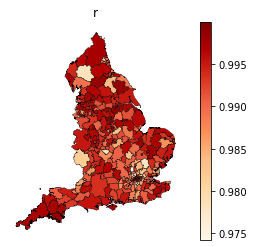

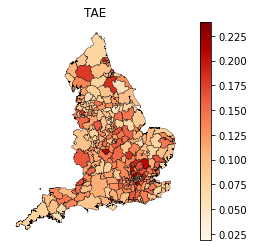

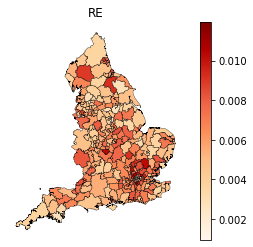

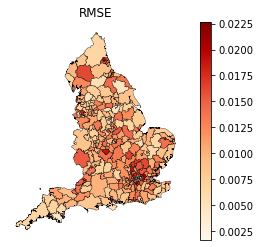

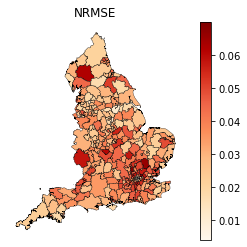

In [31]:
import matplotlib.pyplot as plt
floor_error_map.plot(column="r", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('r')
plt.axis('off')

floor_error_map.plot(column="tae", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('TAE')
plt.axis('off')

floor_error_map.plot(column="re", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('RE')
plt.axis('off')

floor_error_map.plot(column="rmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('RMSE')
plt.axis('off')

floor_error_map.plot(column="nrmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('NRMSE')
plt.axis('off')

### RMSE

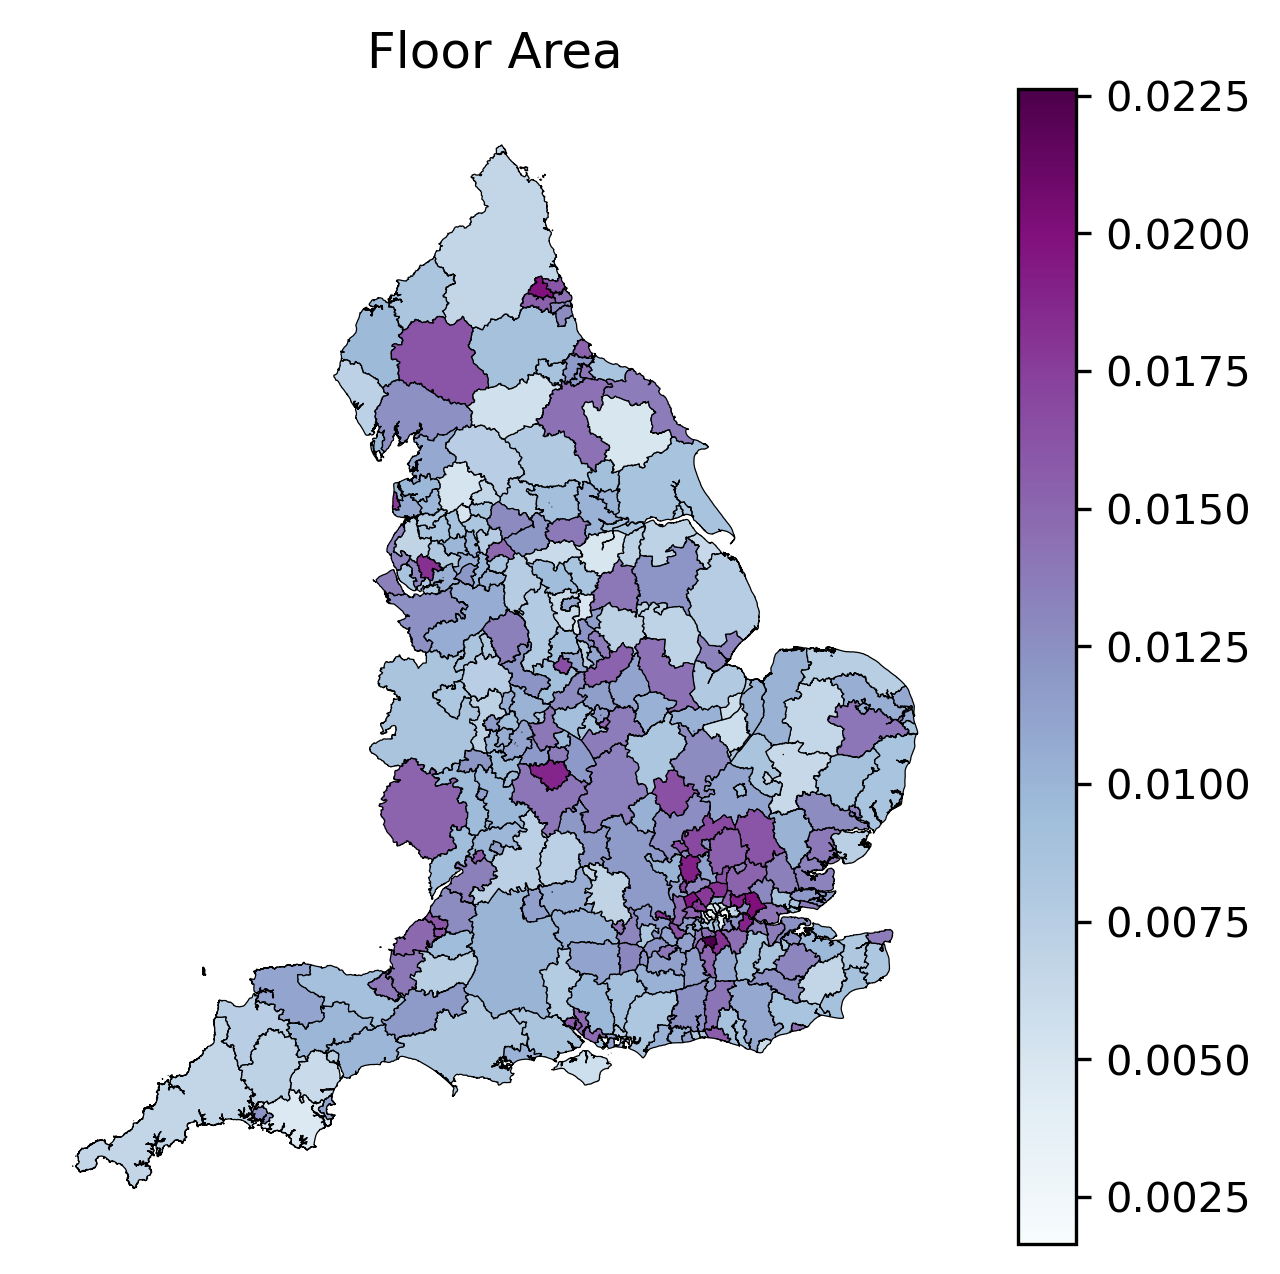

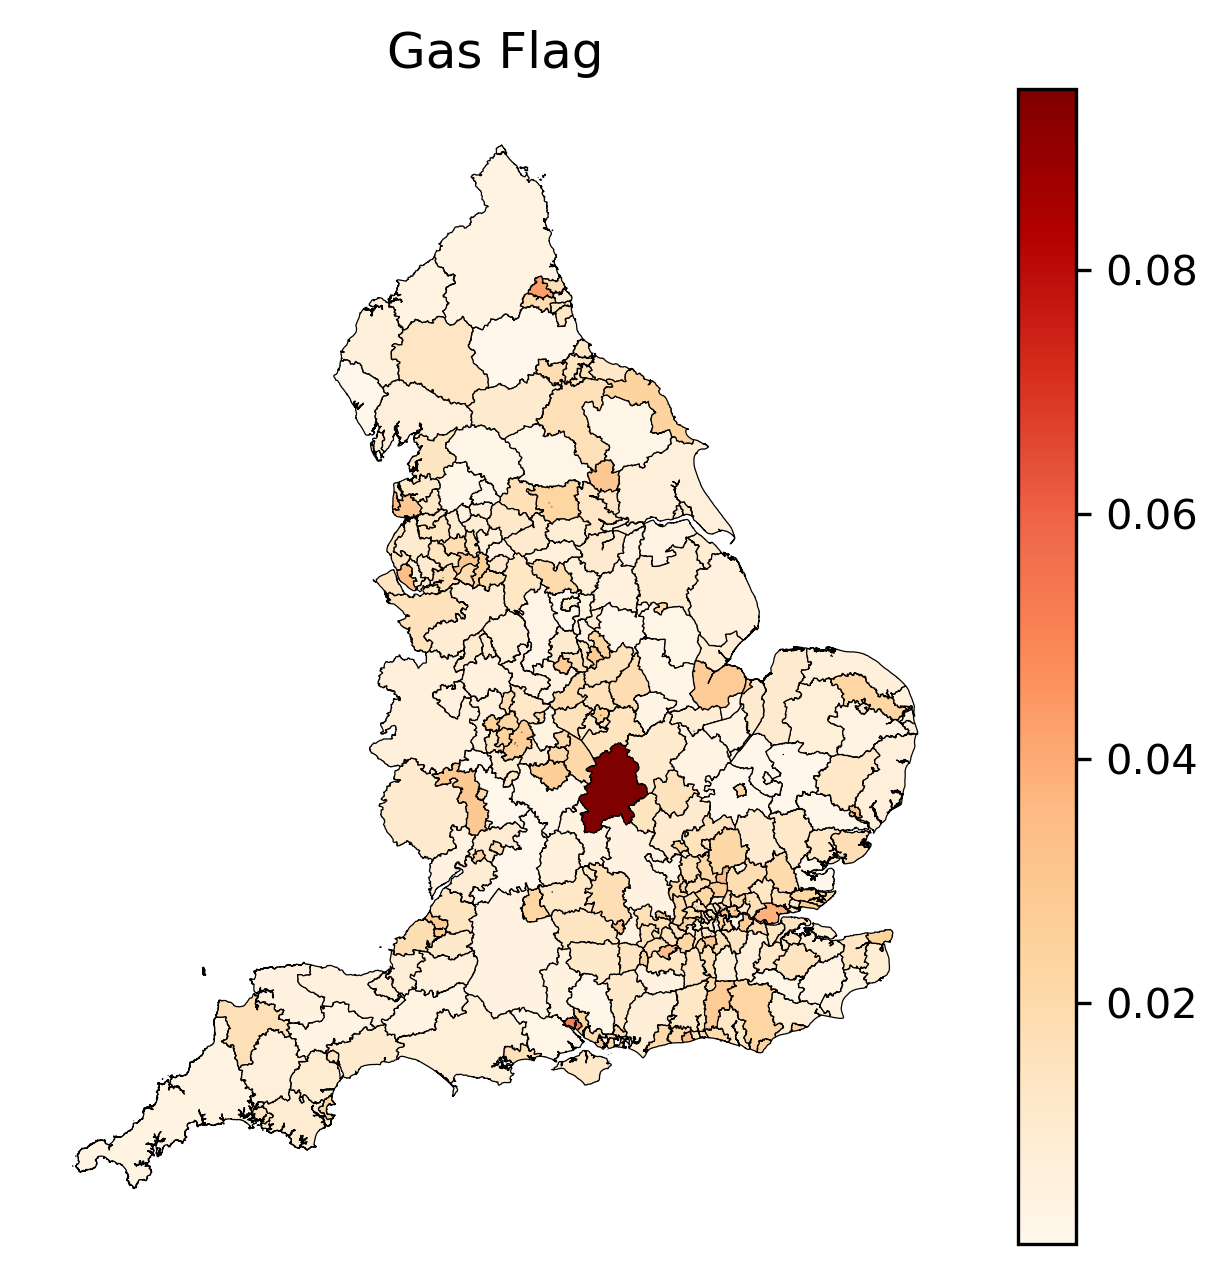

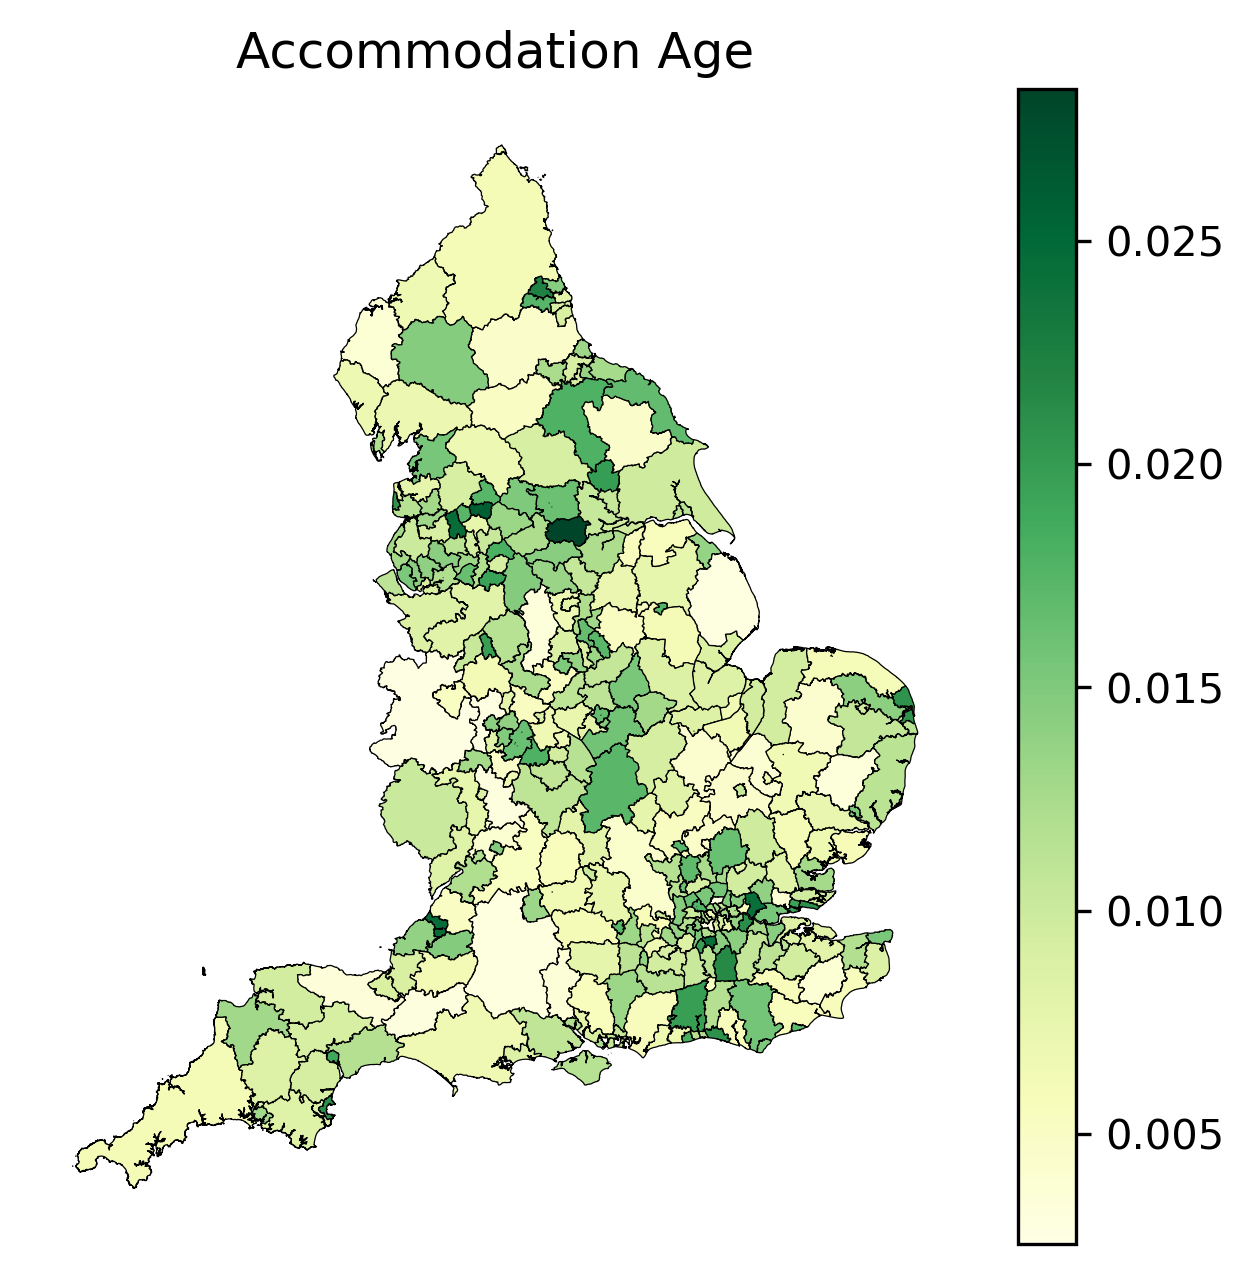

In [32]:

plt.rcdefaults() 
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
floor_error_map.plot(ax=ax, column="rmse", cmap='BuPu', edgecolor='k', linewidth=0.3, legend=True)
plt.title('Floor Area')
plt.axis('off')
plt.savefig("FA_RSME_byLA", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
gas_error_map.plot(ax=ax,column="rmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('Gas Flag')
plt.axis('off')
plt.savefig("GF_RSME_byLA", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5,5), dpi=300)
age_error_map.plot(ax=ax,column="rmse", cmap='YlGn', edgecolor='k', linewidth=0.3, legend=True)
plt.title('Accommodation Age')
plt.axis('off')
plt.savefig("AA_RSME_byLA", dpi=300, bbox_inches='tight')


In [33]:
sort_gas = gas_error_map.sort_values('rmse', axis=0, ascending=False)

In [34]:
sort_gas.head(-5)

,ladcd,geometry,code,ladnm,r,tae,re,rmse,nrmse
58,E06000062,"POLYGON ((455000.094 231353.812, 454800.625 23...",E00138311,West Northamptonshire,1.0,0.134063,0.067031,0.094797,0.547990
42,E06000045,"POLYGON ((438978.601 111742.000, 438707.501 11...",E00166958,Southampton,1.0,0.072354,0.036177,0.051162,0.169584
259,E08000021,"POLYGON ((418534.000 564448.100, 418495.900 56...",E00175572,Newcastle upon Tyne,1.0,0.060588,0.030294,0.042842,0.275744
31,E06000034,"MULTIPOLYGON (((556313.100 177222.600, 556156....",E00080915,Thurrock,1.0,0.054250,0.027125,0.038361,0.198216
120,E07000095,"POLYGON ((534809.135 200113.963, 534527.083 20...",E00118499,Broxbourne,1.0,0.051336,0.025668,0.036300,0.208994
...,...,...,...,...,...,...,...,...,...
67,E07000029,"MULTIPOLYGON (((297008.600 510588.500, 296928....",E00097341,Copeland,1.0,0.001309,0.000654,0.000925,0.006005
104,E07000079,"POLYGON ((383121.290 187218.893, 383112.000 18...",E00112902,Cotswold,1.0,0.001270,0.000635,0.000898,0.002088
63,E07000012,"POLYGON ((528910.494 238465.347, 528896.813 23...",E00092134,South Cambridgeshire,1.0,0.001142,0.000571,0.000807,0.002690
238,E07000245,"POLYGON ((564567.813 245236.203, 564592.313 24...",E00152497,West Suffolk,1.0,0.001127,0.000564,0.000797,0.002360


In [35]:
lad_code = 'E06000062'
test = population_df.loc[population_df.LADCD == lad_code].reset_index(drop=True)
test1 = epc_df.loc[epc_df.LADCD == lad_code].reset_index(drop=True)

<AxesSubplot:>

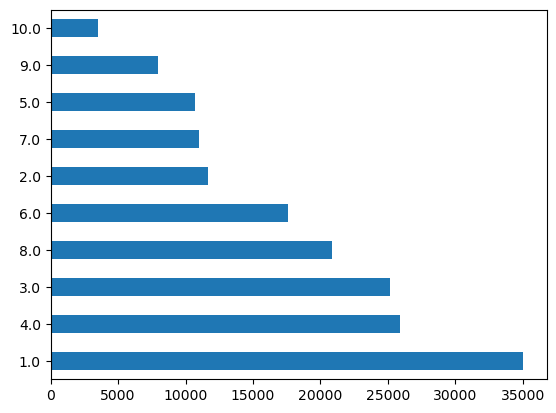

In [36]:
test.ACCOM_AGE.value_counts().plot(kind='barh')

### Haringey

In [37]:
lad_code = 'E09000014'
population_lad_df = population_df.loc[population_df.LADCD == lad_code].reset_index(drop=True)
epc_lad_df = epc_df.loc[epc_df.LADCD == lad_code].reset_index(drop=True)

In [38]:
population_lad_df.head()

,HID,LADNM,LADCD,OA,LC4402_C_TYPACCOM,LC4402_C_TENHUK11,LC4408_C_AHTHUK11,LC4404_C_SIZHUK11,LC4404_C_ROOMS,LC4405EW_C_BEDROOMS,LC4402_C_CENHEATHUK11,LC4605_C_NSSEC,LC4202_C_ETHHUK11,LC4202_C_CARSNO,FLOOR_AREA,GAS,ACCOM_AGE
0,0.0,Haringey,E09000014,E00010088,3,3.0,3.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,1.0
1,1.0,Haringey,E09000014,E00010222,2,5.0,1.0,1.0,3.0,1.0,2.0,9.0,7.0,1.0,3.0,2.0,8.0
2,2.0,Haringey,E09000014,E00010300,5,6.0,2.0,4.0,6.0,4.0,2.0,4.0,4.0,1.0,2.0,2.0,1.0
3,4.0,Haringey,E09000014,E00010345,5,6.0,3.0,2.0,4.0,1.0,2.0,5.0,4.0,1.0,3.0,2.0,1.0
4,5.0,Haringey,E09000014,E00010339,4,3.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,3.0,2.0,1.0


In [39]:
internal_validation_haringey = []
bins = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [-1,0,1],
        [0,1,2,3,4,5,6,7,8,9,10]
       ]

for constraint, bin in zip(constraints,bins):
    obs = epc_lad_df[constraint].value_counts(bins=bin, normalize=True).sort_index()
    sim = population_lad_df[constraint].value_counts(bins=bin, normalize=True).sort_index()
    internal_validation_haringey.append(stats(obs, sim, constraint))
    
pd.DataFrame.from_dict(internal_validation_haringey)


20
2
10


,constraint,r,tae,re,rmse,nrmse
0,FLOOR_AREA,0.996212,0.128960,0.006448,0.010234,0.029835
1,GAS,1.000000,0.012297,0.006149,0.008695,0.090640
2,ACCOM_AGE,0.999867,0.020493,0.002049,0.002770,0.005230


In [40]:
def stats_oa(obs, sim, lad):
    obs_lad = obs.loc[lad]
    sim_lad = sim.loc[lad]
    
    # Pearson’s correlation
    r = obs_lad.corr(sim_lad, method='pearson')

    errors = obs_lad.values - sim_lad.values
    n = len(errors)

    # Total absolute error
    tae = sum(abs(errors))

    # Relative error
    re = tae/n

    # Root mean squared error
    rmse = math.sqrt(sum(errors**2)/n)

    # Normalised root mean error squared
    nrmse = rmse/(max(obs_lad)-min(obs_lad))

    stats = {
        'OA':lad,
        'r': r,
        'tae': tae,
        're': re,
        'rmse': rmse,
        'nrmse': nrmse
    }

    return stats

In [41]:
internal_validation_local_haringey = []
bins = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [-1,0,1],
        [0,1,2,3,4,5,6,7,8,9,10]
       ]

oa_codes = epc_lad_df['OA'].unique()
for constraint, bin in zip(constraints,bins):
    obs = epc_lad_df.groupby('OA')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    sim = population_lad_df.groupby('OA')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    print(constraint, '--------------')
    stat = []
    for oa in oa_codes:
        try:
            stat.append(stats_oa(obs, sim, oa))
        except:
            print(oa)
    internal_validation_local_haringey.append(stat)

FLOOR_AREA --------------
GAS --------------
E00170306
E00010016
E00009993
E00010101
E00009956
E00010308
E00010250
E00010348
E00010544
E00010503
E00009907
E00010318
E00010282
E00009865
E00010224
E00170317
E00010454
E00010448
E00010140
E00010405
E00009833
E00010211
E00010499
E00009866
E00009880
E00010390
E00010225
E00010231
E00010022
E00010062
E00010473
E00010289
E00010298
E00010195
E00010307
E00010510
E00010400
E00010319
E00010517
E00010226
E00010217
E00010453
E00010378
E00010229
E00010244
E00009886
E00010506
E00010107
E00009994
E00010153
E00010137
E00010404
E00010262
E00010008
E00010177
E00010115
E00010019
E00010343
E00010121
E00010047
E00010223
E00010466
E00010119
E00009882
E00009971
E00010213
E00010067
E00010198
E00010072
E00010557
E00010130
E00010281
E00010210
E00010370
E00010189
E00010157
E00010045
E00010459
E00010552
E00010051
E00010267
E00010204
E00009885
E00010230
E00010118
E00010044
E00010458
E00010123
E00010511
E00009934
E00010259
E00010181
E00010371
E00010310
E00010117
E0001

In [42]:
#haringey.reset_index(inplace=True)
haringey.rename(columns={"code":"OA"}, inplace=True)
haringey.head()

/tmp/ipykernel_251670/1844159763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haringey.rename(columns={"code":"OA"}, inplace=True)


,OA,geometry,ladnm,ladcd
9507,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014
37942,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014
53149,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014
54506,E00010567,"POLYGON ((530741.574 190314.679, 530465.438 19...",Haringey,E09000014
54507,E00010561,"POLYGON ((530540.380 190726.024, 530575.754 19...",Haringey,E09000014


In [43]:
local_stats_floor_haringey = pd.DataFrame.from_dict(internal_validation_local_haringey[0])

In [44]:
local_stats_floor_haringey.head()

,OA,r,tae,re,rmse,nrmse
0,E00009848,0.975142,0.269156,0.013458,0.022561,0.071838
1,E00170306,0.942864,0.603562,0.030178,0.065818,0.086602
2,E00010016,0.831645,0.585353,0.029268,0.041585,0.149330
3,E00009993,0.696347,0.602044,0.030102,0.048406,0.214800
4,E00010003,0.957798,0.423778,0.021189,0.041370,0.081621


In [45]:
floor_error_map_haringey = pd.merge(haringey, local_stats_floor_haringey, on='OA',how='left')

In [46]:
floor_error_map_haringey.head()

,OA,geometry,ladnm,ladcd,r,tae,re,rmse,nrmse
0,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014,0.919747,0.414414,0.020721,0.046892,0.134816
1,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014,0.948180,0.325403,0.016270,0.027367,0.095026
2,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014,0.986865,0.235589,0.011779,0.029396,0.049489
3,E00010567,"POLYGON ((530741.574 190314.679, 530465.438 19...",Haringey,E09000014,0.798959,0.518008,0.025900,0.060629,0.139912
4,E00010561,"POLYGON ((530540.380 190726.024, 530575.754 19...",Haringey,E09000014,0.846717,0.593137,0.029657,0.055825,0.206311


(526385.4036000001, 536173.2784, 186532.82880000002, 192167.5612)

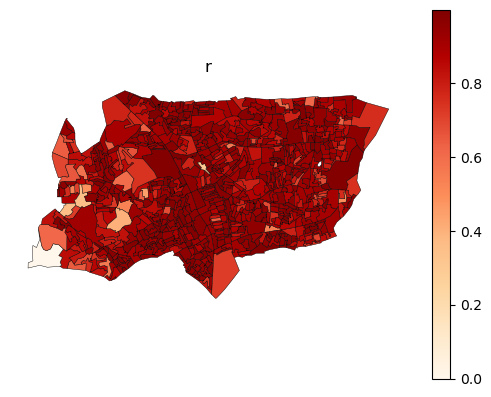

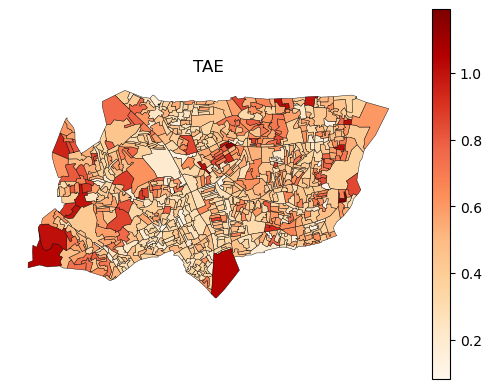

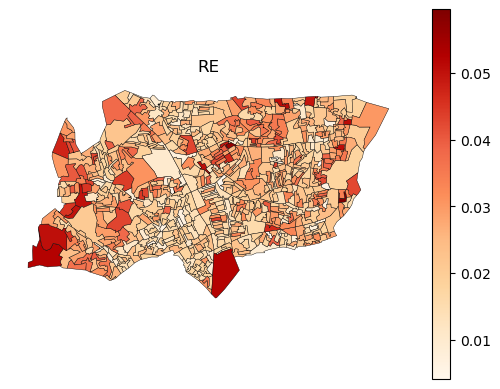

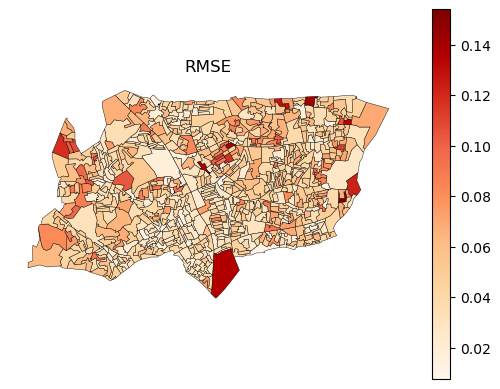

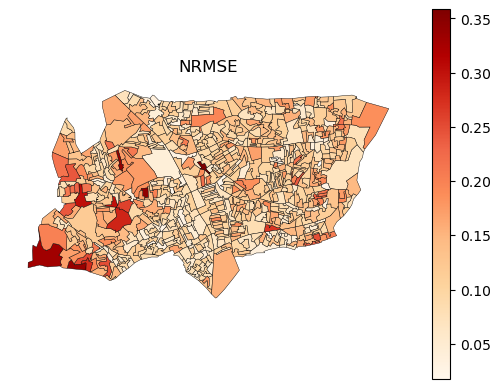

In [47]:
import matplotlib.pyplot as plt
floor_error_map_haringey.plot(column="r", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('r')
plt.axis('off')

floor_error_map_haringey.plot(column="tae", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('TAE')
plt.axis('off')

floor_error_map_haringey.plot(column="re", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('RE')
plt.axis('off')

floor_error_map_haringey.plot(column="rmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('RMSE')
plt.axis('off')

floor_error_map_haringey.plot(column="nrmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)
plt.title('NRMSE')
plt.axis('off')

In [48]:
import numpy as np
errors = np.array([1,-1, 2,-2])
print(sum(abs(errors)))

6


In [49]:
gas_error_map.head()

,ladcd,geometry,code,ladnm,r,tae,re,rmse,nrmse
0,E06000001,"MULTIPOLYGON (((449414.701 526577.401, 449419....",E00060514,Hartlepool,1.0,0.018606,0.009303,0.013157,0.205641
1,E06000002,"MULTIPOLYGON (((448245.000 513149.500, 448109....",E00060595,Middlesbrough,1.0,0.022517,0.011258,0.015922,0.202221
2,E06000003,"MULTIPOLYGON (((453438.189 515372.081, 453314....",E00061246,Redcar and Cleveland,1.0,0.017153,0.008577,0.012129,0.136363
3,E06000004,"MULTIPOLYGON (((440535.438 510766.594, 440422....",E00061749,Stockton-on-Tees,1.0,0.020981,0.010491,0.014836,0.225092
4,E06000005,"POLYGON ((425869.813 512872.594, 425791.000 51...",E00062210,Darlington,1.0,0.026020,0.013010,0.018399,0.174779


In [50]:
sort_gas.head(-5)

,ladcd,geometry,code,ladnm,r,tae,re,rmse,nrmse
58,E06000062,"POLYGON ((455000.094 231353.812, 454800.625 23...",E00138311,West Northamptonshire,1.0,0.134063,0.067031,0.094797,0.547990
42,E06000045,"POLYGON ((438978.601 111742.000, 438707.501 11...",E00166958,Southampton,1.0,0.072354,0.036177,0.051162,0.169584
259,E08000021,"POLYGON ((418534.000 564448.100, 418495.900 56...",E00175572,Newcastle upon Tyne,1.0,0.060588,0.030294,0.042842,0.275744
31,E06000034,"MULTIPOLYGON (((556313.100 177222.600, 556156....",E00080915,Thurrock,1.0,0.054250,0.027125,0.038361,0.198216
120,E07000095,"POLYGON ((534809.135 200113.963, 534527.083 20...",E00118499,Broxbourne,1.0,0.051336,0.025668,0.036300,0.208994
...,...,...,...,...,...,...,...,...,...
67,E07000029,"MULTIPOLYGON (((297008.600 510588.500, 296928....",E00097341,Copeland,1.0,0.001309,0.000654,0.000925,0.006005
104,E07000079,"POLYGON ((383121.290 187218.893, 383112.000 18...",E00112902,Cotswold,1.0,0.001270,0.000635,0.000898,0.002088
63,E07000012,"POLYGON ((528910.494 238465.347, 528896.813 23...",E00092134,South Cambridgeshire,1.0,0.001142,0.000571,0.000807,0.002690
238,E07000245,"POLYGON ((564567.813 245236.203, 564592.313 24...",E00152497,West Suffolk,1.0,0.001127,0.000564,0.000797,0.002360


# External Validation

In [51]:
import yaml

In [52]:
# haringey_validation_by_postcode.csv
ext_haringey = pd.read_csv('haringey_validation_by_postcode.csv')
ext_haringey.head()

,Unnamed: 0,Postcode,BuiltForm,Tenure,HabitableRoomCount,MainsGas,ConstructionAgeBand,totalfloorarea
0,10,N10 1HT,MidTerrace,RentedSocial,3,Y,C,61.0
1,11,N10 1HU,MidTerrace,RentedSocial,6,Y,C,85.0
2,12,N10 1JD,SemiDetached,OwnerOccupied,4,Y,B,110.0
3,13,N10 1JG,MidTerrace,RentedSocial,3,Y,C,74.0
4,14,N10 1JH,EndTerrace,RentedSocial,5,Y,C,85.0


## Construction Age Band:

|Band | Age lower | Age higher | Code |
| --- | --- | --- | --- |
| A | - | up to 1900/1919/1919| 1 |
| B | A  |29| 1 |
| C | 30 |49| 2 |
| D | C | 73| 3*|
| E | D | 77| 4*|
| F | E | 85| 5|
| G | F | 91| 6|
| H | G | 99| 7/8|

In [55]:
# Configure lookups from "config/lookups.yaml" file
lookup_yaml = open("../../config/lookups.yaml")
parsed_lookup = yaml.load(lookup_yaml, Loader=yaml.FullLoader)
# url = parsed_lookup.get("area_url")

# Open file as Pandas DataFrame
area_lookup = pd.read_csv(
    '../input/PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.zip',
    compression="zip",
    usecols=["ladnm", "ladcd", "oa11cd", "pcds"],
    encoding="unicode_escape",
    engine="python",
)

# Clean empty and non-England areas
area_lookup.dropna(subset=["ladcd"], inplace=True)
discard = ["S", "W", "N", "L", "M"]
area_lookup = area_lookup[~area_lookup.ladcd.str.contains("|".join(discard))]
lads = area_lookup.ladcd.unique()

# Make lookup dictionaries
oacd_lookup = area_lookup.set_index("pcds", drop=True).loc[:, "oa11cd"].to_dict()

In [56]:
ext_haringey["OA"] = ext_haringey["Postcode"].apply(func=lambda x: augment(x, oacd_lookup))

In [57]:
ext_haringey.shape

(1168, 9)

In [58]:
floor_area_lookup = parsed_lookup.get("floor_area")
gas_lookup = parsed_lookup.get("gas")
# age_lookup = parsed_lookup.get("age_hr")
age_lookup =  { 'A': 1, 'B': 1, 'C': 2, 'D': 3, 'E': 4,}



In [59]:
def set_numerical_code(df, df_col, lookup, rename=False):
    """Apply the lookup to a numerical column

    Transform the values in a dataframe column using a lookup dictionary.
    This method is valid when the column values are numerical, following
    the rule:

    if (j < value <= k), then, (value = i).

    :param df: The input dataframe.
    :type df: pandas.DataFrame
    :param df_col: The column in df that represents the numerical values.
    :type df_col: string
    :param lookup: A dictionary from numerical values to numerical codes;
        The dictionary structure is [[i1, j1, k1], [i2, j2, k2], ...,
        [iN, jN, kN]], where: iN is the desired code for band N, jN is the
        minimum value of the band N (not included), kN is the maximum value
        of the band N (included), and N is the number of bands.
    :type lookup: dict
    :param rename: The new column name after transformation (if false, keep
        the current name), defaults to False.
    :type rename: bool, optional
    """
    for band in lookup:
        df.loc[(df[df_col] > band[1]) & (df[df_col] <= band[2]), df_col] = band[0]

    # remove out bound and empty rows
    df.dropna(subset=[df_col], inplace=True)

    if rename:
        df.rename({df_col: rename}, axis=1, inplace=True)

In [60]:
def set_categorical_code(df, df_col, lookup, rename=False):
    """Apply the lookup to a categorical column.

    Transform the values in a dataframe column using a lookup dictionary.
    This method is valid when the column values are categorical.

    :param df:  The input dataframe.
    :type df: pandas.DataFrame
    :param df_col: The column in df that represents the categorical values.
    :type df_col: string
    :param lookup: A dictionary from categorical values to categorical codes.
    :type lookup: dict
    :param rename: The new column name after transformation (if false, keep
        the current name), defaults to False.
    :type rename: bool, optional
    :return: Returns the data with the updated column.
    :rtype: pandas.DataFrame
    """

    # # This looks redundant, but ensures that the function works even for
    # # missing values (returning empty code).
    # def augment(x, lookup):
    #     try:
    #         return lookup[x]
    #     except:
    #         return

    # setting new values according the rename_dict
    df[df_col] = df[df_col].apply(func=lambda x: augment(x, lookup))

    # remove empty rows
    df.dropna(subset=[df_col], inplace=True)

    # rename column
    if rename:
        df.rename({df_col: rename}, axis=1, inplace=True)

In [61]:
set_categorical_code(ext_haringey, "MainsGas", gas_lookup, rename="GAS")
set_numerical_code(ext_haringey, "totalfloorarea", floor_area_lookup, rename="FLOOR_AREA")
set_categorical_code(ext_haringey, "ConstructionAgeBand", age_lookup, rename="ACCOM_AGE")

In [62]:
ext_haringey.head()

,Unnamed: 0,Postcode,BuiltForm,Tenure,HabitableRoomCount,GAS,ACCOM_AGE,FLOOR_AREA,OA
0,10,N10 1HT,MidTerrace,RentedSocial,3,2,2.0,3.0,E00009988
1,11,N10 1HU,MidTerrace,RentedSocial,6,2,2.0,4.0,E00010019
2,12,N10 1JD,SemiDetached,OwnerOccupied,4,2,1.0,5.0,E00010021
3,13,N10 1JG,MidTerrace,RentedSocial,3,2,2.0,3.0,E00010022
4,14,N10 1JH,EndTerrace,RentedSocial,5,2,2.0,4.0,E00010022


In [63]:
haringey

,OA,geometry,ladnm,ladcd
9507,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014
37942,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014
53149,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014
54506,E00010567,"POLYGON ((530741.574 190314.679, 530465.438 19...",Haringey,E09000014
54507,E00010561,"POLYGON ((530540.380 190726.024, 530575.754 19...",Haringey,E09000014
...,...,...,...,...
121970,E00009893,"POLYGON ((530501.835 191441.275, 530465.654 19...",Haringey,E09000014
121973,E00009894,"POLYGON ((530115.712 191398.318, 530057.055 19...",Haringey,E09000014
121974,E00009896,"POLYGON ((529827.194 191719.415, 529835.361 19...",Haringey,E09000014
121977,E00009897,"POLYGON ((529321.553 191455.150, 529339.358 19...",Haringey,E09000014


In [64]:
hr_map = pd.merge(haringey, ext_haringey, on='OA',how='left')

In [65]:
hr_map.head()

,OA,geometry,ladnm,ladcd,Unnamed: 0,Postcode,BuiltForm,Tenure,HabitableRoomCount,GAS,ACCOM_AGE,FLOOR_AREA
0,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014,79.0,N15 4HR,MidTerrace,RentedPrivate,5.0,2.0,4.0,4.0
1,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014,320.0,N22 6SD,MidTerrace,OwnerOccupied,4.0,2.0,1.0,6.0
2,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014,321.0,N22 6SE,MidTerrace,OwnerOccupied,6.0,2.0,2.0,6.0
3,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014,322.0,N22 6SE,MidTerrace,OwnerOccupied,5.0,2.0,1.0,5.0
4,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014,619.0,N17 6LR,EndTerrace,OwnerOccupied,3.0,2.0,4.0,3.0


<AxesSubplot:>

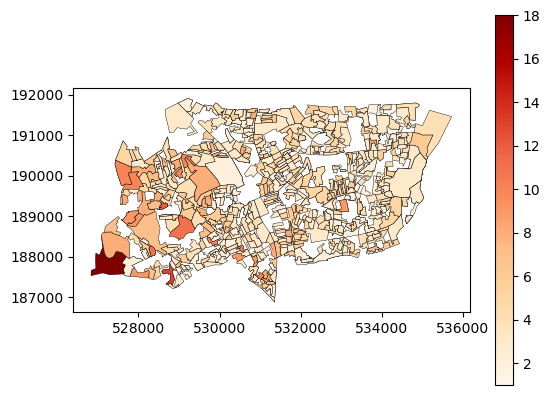

In [66]:
hr_map.plot(column="FLOOR_AREA", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)

In [67]:
constraints = ['FLOOR_AREA', 'GAS', 'ACCOM_AGE']
external_validation_local_haringey = []
bins = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [-1,0,1],
        [0,1,2,3,4,5,6,7]
       ]

oa_codes = epc_lad_df['OA'].unique()
for constraint, bin in zip(constraints,bins):
    obs = epc_lad_df.groupby('OA')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    sim = ext_haringey.groupby('OA')[constraint].value_counts(bins=bin, normalize=True).sort_index()
    print(constraint, '--------------')
    stat = []
    for oa in oa_codes:
        try:
            stat.append(stats_oa(obs, sim, oa))
        except:
            print(oa)
    external_validation_local_haringey.append(stat)

FLOOR_AREA --------------
E00170306
E00010165
E00009944
E00010202
E00010409
E00009840
E00010250
E00170298
E00009935
E00010084
E00009924
E00010275
E00010503
E00010463
E00170312
E00010192
E00010467
E00010027
E00009878
E00010324
E00010039
E00010416
E00010140
E00010294
E00010346
E00010197
E00010332
E00010530
E00010374
E00010161
E00010235
E00010284
E00010478
E00009955
E00010486
E00009965
E00010017
E00010390
E00010093
E00170310
E00010351
E00010225
E00010231
E00010041
E00010523
E00010094
E00010036
E00010353
E00010473
E00009915
E00010311
E00010030
E00010298
E00009881
E00010358
E00010307
E00010340
E00010099
E00010551
E00010400
E00010218
E00010319
E00010344
E00010461
E00010563
E00010378
E00170315
E00010375
E00009887
E00170309
E00010011
E00170323
E00010229
E00009886
E00010083
E00170322
E00010015
E00010385
E00010312
E00009905
E00010359
E00170316
E00170314
E00010085
E00010008
E00009962
E00170304
E00009850
E00010097
E00010047
E00010138
E00010398
E00010247
E00009858
E00010466
E00010065
E00010527
E000

In [68]:
local_stats_floor_haringey = pd.DataFrame.from_dict(internal_validation_local_haringey[0])
local_stats_floor_haringey.head(-5)

,OA,r,tae,re,rmse,nrmse
0,E00009848,0.975142,0.269156,0.013458,0.022561,0.071838
1,E00170306,0.942864,0.603562,0.030178,0.065818,0.086602
2,E00010016,0.831645,0.585353,0.029268,0.041585,0.149330
3,E00009993,0.696347,0.602044,0.030102,0.048406,0.214800
4,E00010003,0.957798,0.423778,0.021189,0.041370,0.081621
...,...,...,...,...,...,...
742,E00010006,0.716293,0.626680,0.031334,0.055888,0.232378
743,E00010163,0.819812,0.460161,0.023008,0.039191,0.181957
744,E00010426,0.991884,0.182320,0.009116,0.023522,0.043684
745,E00010431,0.836735,0.626176,0.031309,0.075130,0.139527


In [69]:
haringey.head()

,OA,geometry,ladnm,ladcd
9507,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014
37942,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014
53149,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014
54506,E00010567,"POLYGON ((530741.574 190314.679, 530465.438 19...",Haringey,E09000014
54507,E00010561,"POLYGON ((530540.380 190726.024, 530575.754 19...",Haringey,E09000014


In [70]:
hr_map = pd.merge(haringey, local_stats_floor_haringey, on='OA',how='left')

In [71]:
hr_map.head()

,OA,geometry,ladnm,ladcd,r,tae,re,rmse,nrmse
0,E00010413,"POLYGON ((532888.413 189439.936, 532907.227 18...",Haringey,E09000014,0.919747,0.414414,0.020721,0.046892,0.134816
1,E00010184,"POLYGON ((531817.439 189991.561, 531793.973 19...",Haringey,E09000014,0.948180,0.325403,0.016270,0.027367,0.095026
2,E00010469,"POLYGON ((532798.983 190160.259, 532782.850 19...",Haringey,E09000014,0.986865,0.235589,0.011779,0.029396,0.049489
3,E00010567,"POLYGON ((530741.574 190314.679, 530465.438 19...",Haringey,E09000014,0.798959,0.518008,0.025900,0.060629,0.139912
4,E00010561,"POLYGON ((530540.380 190726.024, 530575.754 19...",Haringey,E09000014,0.846717,0.593137,0.029657,0.055825,0.206311


<AxesSubplot:>

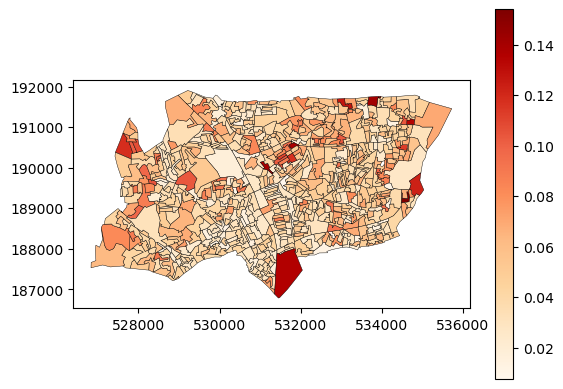

In [72]:
hr_map.plot(column="rmse", cmap='OrRd', edgecolor='k', linewidth=0.3, legend=True)

In [73]:
external_validation_haringey = []
bins = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [-1,0,1],
        [0,1,2,3,4,5,6,7]
       ]

for constraint, bin in zip(constraints,bins):
    obs = epc_lad_df[constraint].value_counts(bins=bin, normalize=True).sort_index()
    sim = ext_haringey[constraint].value_counts(bins=bin, normalize=True).sort_index()
    external_validation_haringey.append(stats(obs, sim, constraint))
    
pd.DataFrame.from_dict(external_validation_haringey)

20
2
7


,constraint,r,tae,re,rmse,nrmse
0,FLOOR_AREA,0.975729,0.255409,0.012770,0.020838,0.060749
1,GAS,1.000000,0.075078,0.037539,0.053088,0.553387
2,ACCOM_AGE,0.997512,0.240569,0.034367,0.046209,0.088623


In [74]:
import seaborn as sns

In [75]:
bins1 = [
        [0,1,2,3,4,5,6,7],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [0,1,2],
       ]

constraints = ['ACCOM_AGE', 'FLOOR_AREA', 'GAS']
xlabels = ["Accommodation Age", "Floor area", "Gas Flag"]

if not (os.path.exists("../data/output/exsternalFIGs")):
    os.makedirs("../data/output/exsternalFIGs")

colours = sns.color_palette()

df1 = epc_lad_df
df2 = ext_haringey

j = 0
sns.set(color_codes=True)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
for constraint in constraints:

    y_epc = df1[constraint].value_counts(bins=bins1[j], normalize=True).sort_index()
    y_msm = df2[constraint].value_counts(bins=bins1[j], normalize=True).sort_index()

    sns.barplot(ax=ax[j][0], x=bins1[j][1:], y=y_epc, color = colours[0])
    sns.barplot(ax=ax[j][1], x=bins1[j][1:], y=y_msm, color = colours[3])

    for k in range(2):
        ax[j][k].set_xlabel(xlabels[j])
        ax[j][k].set_ylabel("Frequency")

    lad_name = 'Haringey'
    lad_code = 'E09000014'
    j = j + 1

ax[0][0].set_title("External Haringey Data")
ax[0][1].set_title("Enriched SPENSER")

ax[0][0].set_ylim([0, 0.6])
ax[0][1].set_ylim([0, 0.6])

ax[1][0].set_ylim([0, 0.35])
ax[1][1].set_ylim([0, 0.35])

ax[2][0].set_ylim([0, 1])
ax[2][1].set_ylim([0, 1])

fig.tight_layout(pad=3.0)
fig_name = "_".join([lad_code, lad_name, "validation.png"])
fig_name = os.path.join("../data/output/exsternalFIGs/", fig_name)
plt.savefig(fig_name)
plt.close()

In [76]:
from scipy.stats import chi2_contingency
table = [[10, 20, 30],[10,  20,  30]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably independent')
else:
	print('Probably dependent')

stat=0.000, p=1.000
Probably independent


In [77]:
bins1 = [
        [0,1,2,3,4,5,6,7],
        [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
        [0,1,2],
       ]

constraints = ['ACCOM_AGE', 'FLOOR_AREA', 'GAS']

for constraint, bin in zip(constraints,bins1):
    obs = epc_lad_df[constraint].value_counts(bins=bin).sort_index()
    sim = ext_haringey[constraint].value_counts(bins=bin).sort_index()
    print(constraint, bin)
    print(obs, sim)

ACCOM_AGE [0, 1, 2, 3, 4, 5, 6, 7]
(-0.001, 1.0]    42953
(1.0, 2.0]       12467
(2.0, 3.0]        4977
(3.0, 4.0]        6549
(4.0, 5.0]        3107
(5.0, 6.0]        2154
(6.0, 7.0]        1917
Name: ACCOM_AGE, dtype: int64 (-0.001, 1.0]    626
(1.0, 2.0]       165
(2.0, 3.0]        75
(3.0, 4.0]        93
(4.0, 5.0]         0
(5.0, 6.0]         0
(6.0, 7.0]         0
Name: ACCOM_AGE, dtype: int64
FLOOR_AREA [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
(-0.001, 1.0]     4904
(1.0, 2.0]       17471
(2.0, 3.0]       27000
(3.0, 4.0]       15350
(4.0, 5.0]        6737
(5.0, 6.0]        3131
(6.0, 7.0]        1742
(7.0, 8.0]         938
(8.0, 9.0]         532
(9.0, 10.0]        329
(10.0, 11.0]       198
(11.0, 12.0]       149
(12.0, 13.0]        74
(13.0, 14.0]        32
(14.0, 15.0]        41
(15.0, 16.0]        31
(16.0, 17.0]        12
(17.0, 18.0]        16
(18.0, 19.0]        10
(19.0, 20.0]         4
Name: FLOOR_AREA, dtype: int64 (-0.001, 1.0]     14

In [78]:
from scipy.stats import chisquare

d1 = [0.545775, 0.158410, 0.063239, 0.083214, 0.039479, 0.027369, 0.024358]
d2 = [0.583411, 0.153774, 0.069897, 0.086673, 0.042870, 0.043802, 0.019571] 

print(sum(d1), sum(d2))

# chisquare(d2, f_exp=d1)

0.9418440000000001 0.9999979999999999


In [79]:
from scipy import stats

In [80]:
d1 = [0.545775, 0.158410, 0.063239, 0.083214, 0.039479, 0.027369, 0.024358]
d2 = [0.583411, 0.153774, 0.069897, 0.086673, 0.042870, 0.043802, 0.019571] 

In [81]:
d1 = np.array([4904, 17471, 27000, 15350, 6737, 3131, 1742, 938, 532, 329, 198])
d2 = np.array([16, 219, 331, 211, 126, 72, 33, 34, 10, 8, 6])

In [82]:
d1 = np.array([7550, 71151])
d2 = np.array([32, 1041])

In [83]:
sum(d1/sum(d1))

1.0

In [84]:
chisquare(d2/sum(d2), f_exp=d1/sum(d1))

Power_divergenceResult(statistic=0.05039227645137931, pvalue=0.8223820840858986)

In [85]:
chisquare(d1/sum(d1), f_exp=d2/sum(d2))

Power_divergenceResult(statistic=0.15105328434632884, pvalue=0.6975308274045915)